In [ ]:
!pip install -q mediapy
import mediapy as media
import cv2
import numpy as np

# Ejercicio 5

**Video base**

In [ ]:
url = 'video-persona-aparece.mp4'
video = media.read_video(url)
media.show_video(video)

**Funciones generales**

In [ ]:
def process_image(new_image, prev_image, **kwargs):
    new_image_float = new_image.astype(np.float32)
    new_image_float *= 0.5
    new_image_uint8 = np.clip(new_image_float, 0, 255).astype(np.uint8)

    return new_image_uint8

def draw_contours(frame, contours, color=(0, 255, 0), thickness=2):
    # Comprobar si la imagen es en escala de grises (1 canal)
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        # Convertir la imagen de escala de grises a color (3 canales)
        result_image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        # Si ya es una imagen de color, simplemente hacer una copia
        result_image = frame.copy()

    # Dibujar cada contorno en la imagen
    for contour in contours:
        # Obtener el rectángulo delimitador para cada contorno
        x, y, w, h = cv2.boundingRect(contour)
        # Dibujar el rectángulo
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, thickness)

    return result_image

# Función para procesar un video:
def video_processor(filename_in, filename_out, process_func, max_time=10, **kwargs):
    # Abrir el video de entrada para lectura
    with media.VideoReader(filename_in) as r:
        # Crear un archivo de video de salida
        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:
            count = 0  # Inicializar contador de fotogramas
            prev_image = None  # Inicializar la imagen previa

            # Iterar sobre cada imagen (fotograma) del video
            for image in r:
                new_image = media.to_uint8(image)  # Convertir la imagen a formato flotante

                # Comprobar si es la primera imagen
                if prev_image is None:
                    prev_image = new_image.copy()

                # Procesar la imagen utilizando la función dada
                processed_image = process_func(new_image, prev_image, **kwargs)

                # Añadir la imagen procesada al video de salida
                w.add_image(processed_image)

                # Actualizar la imagen previa
                prev_image = new_image.copy()

                # Incrementar el contador de fotogramas
                count += 1

                # Detener el proceso si se alcanza el tiempo máximo
                if count >= max_time * r.fps:
                    break

**Frame Difference**

In [ ]:
def process_frame_difference(new_image, prev_image, **kwargs):
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    frame_diff = cv2.absdiff(new_gray, prev_gray)

    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)

    _, thresh = cv2.threshold(norm_diff, 120, 255, cv2.THRESH_BINARY)

    return cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)


filename_out = 'frame_difference.mp4'
video_processor(url, filename_out, process_frame_difference, 10)
media.show_video(media.read_video(filename_out), fps=30)

**Optical flow - Sparse**

In [ ]:
def process_sparse_optical_flow(new_image, prev_image):
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    prev_gray_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)

    if not hasattr(process_sparse_optical_flow, "shi_tomasi_done"):
        feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
        process_sparse_optical_flow.prev_points = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
        process_sparse_optical_flow.mask = np.zeros_like(new_image)
        process_sparse_optical_flow.shi_tomasi_done = True

    if process_sparse_optical_flow.shi_tomasi_done:
        prev_points = process_sparse_optical_flow.prev_points
        mask = process_sparse_optical_flow.mask

    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)

    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        new_image = cv2.circle(new_image, (a, b), 3, color, -1)

    output = cv2.add(new_image, mask)
    process_sparse_optical_flow.prev_points = good_new.reshape(-1, 1, 2)
    return output


filename_out = 'sparse_optical_flow.mp4'
video_processor(url, filename_out, process_sparse_optical_flow, max_time=10)

media.show_video(media.read_video(filename_out), fps=30)

**Optical flow - Dense**

In [ ]:
def process_dense_optical_flow(new_image, prev_image):
    gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    if not hasattr(process_dense_optical_flow, "init_done"):
        process_dense_optical_flow.prev_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        process_dense_optical_flow.mask = np.zeros_like(new_image)
        process_dense_optical_flow.mask[..., 1] = 255
        process_dense_optical_flow.init_done = True

    if process_dense_optical_flow.init_done:
        prev_gray = process_dense_optical_flow.prev_gray
        mask = process_dense_optical_flow.mask

    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    process_dense_optical_flow.prev_grayprev_gray = gray.copy()
    return rgb


filename_out = 'highway_process_dense_optical_flow.mp4'
video_processor(url, filename_out, process_dense_optical_flow, max_time=20)

media.show_video(media.read_video(filename_out), fps=30)

**Comentarios y discusion**



*   Utilizando el metodo de frame difference se observa gran cantidad de ruido, propio del metodo y el ruido introducido por el sensor de la camara. Al momento de pasar la persona este ruido se disminuye y se detecta la figura de la persona (para lograr una mejor deteccion es posible agregar dilatacion).
*   Optical flow Sparse: Al comienzo del video observamos los puntos seleccionados para hacer seguimiento (shi_tomasi_done). En el momento de aparecer la persona hace el seguimiento correcto a partir de esos puntos.
*   Optical Flow Dense: Se observa gran cantidad de ruido con la ausencia de la persona. Al aparecer esta puede observarse como el ruido desaparece y hace el seguimiento. Es importante destacar que identifica "distintos movimientos" dentro de la persona, ya que brazos y piernas siguen un movimiento distinto y no se mueve como un bloque (como podria hacerlo un auto en una autopista).







# Ejercicio 6


La localizacion de imagenes implica identificar de alguna forma (por ejemplo bounding box) la posicion de determinado objeto en la imagen; mientras que la clasificacion tiene como output el resultado de la clasificacion (por ejemplo que en la imagen hay un gato) pero no indica nada en la imagen.

Clasificacion:
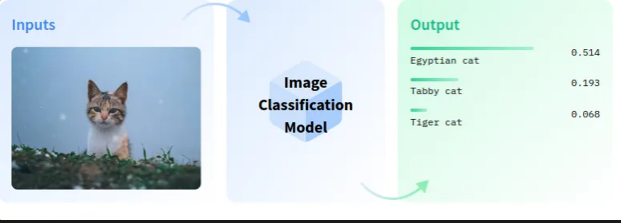

Localizacion:

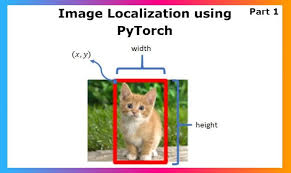

Clasificacion + Localizacion + Deteccion de objetos:


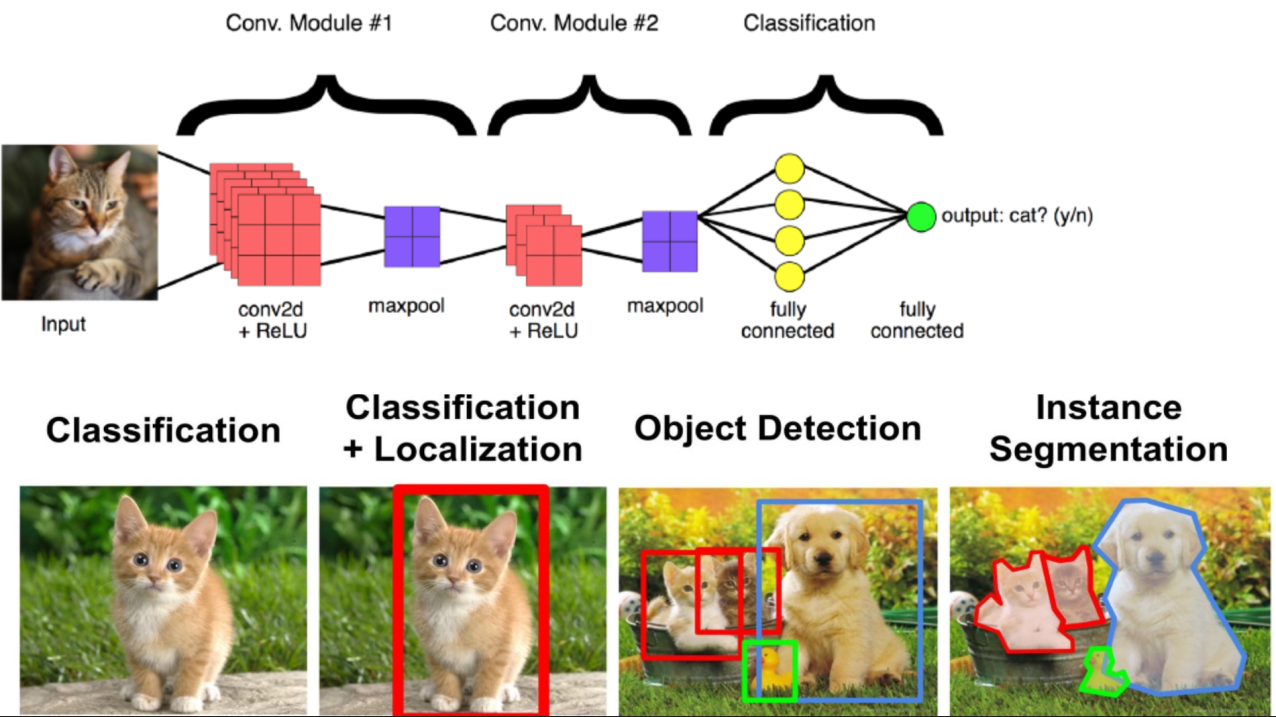